In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

from proj1_helpers import *
from implementations import *
import sklearn
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import cross_validate, cross_val_score, KFold, LeaveOneOut, ShuffleSplit, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

In [3]:
# Load data with panda, replace s and b
import pandas as pd
DATA_TRAIN_PATH = '../data/train.csv'
DATA_TEST_PATH = '../data/test.csv'
df = pd.read_csv(DATA_TRAIN_PATH)
df_test = pd.read_csv(DATA_TEST_PATH)
df['Prediction']=df['Prediction'].replace(['b'], -1).replace(['s'], 1)
df_test['Prediction']=df_test['Prediction'].replace(['b'], -1).replace(['s'], 1)
df.head()

,Id,Prediction,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
0,100000,1,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,...,-0.277,258.733,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497
1,100001,-1,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,...,-1.916,164.546,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226
2,100002,-1,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,...,-2.186,260.414,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251
3,100003,-1,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,...,0.060,86.062,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000
4,100004,-1,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,...,-0.871,53.131,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000


In [4]:
X_train = df.iloc[:,2:]
X_test = df_test.iloc[:,2:]
Y_train = df.iloc[:,1]
Y_test = df_test.iloc[:,1]

In [8]:
#Percentage of outliers per features
perc=(df.iloc[:, :]<= -999.0).sum(axis=0)/X_train.shape[0]*100 #
perc

Id                              0.0000
Prediction                      0.0000
DER_mass_MMC                   15.2456
DER_mass_transverse_met_lep     0.0000
DER_mass_vis                    0.0000
DER_pt_h                        0.0000
DER_deltaeta_jet_jet           70.9828
DER_mass_jet_jet               70.9828
DER_prodeta_jet_jet            70.9828
DER_deltar_tau_lep              0.0000
DER_pt_tot                      0.0000
DER_sum_pt                      0.0000
DER_pt_ratio_lep_tau            0.0000
DER_met_phi_centrality          0.0000
DER_lep_eta_centrality         70.9828
PRI_tau_pt                      0.0000
PRI_tau_eta                     0.0000
PRI_tau_phi                     0.0000
PRI_lep_pt                      0.0000
PRI_lep_eta                     0.0000
PRI_lep_phi                     0.0000
PRI_met                         0.0000
PRI_met_phi                     0.0000
PRI_met_sumet                   0.0000
PRI_jet_num                     0.0000
PRI_jet_leading_pt       

In [ ]:
for i in range(1,30):
    plt.figure(i)
    plt.plot(tX[:,i],y,'bo')
    plt.title('{:.0f}'.format(i))

In [305]:
corr_inf = abs(df.corr())<0.5
corr_inf = corr_inf.iloc[2:,2:]
corr_inf

for i in range(0,30):
    for j in range (0,30):
        if corr_inf.iloc[i,j]==False:
            print(corr_inf.index[i], '--', corr_inf.columns[j])
            
# DER_pt_h
# DER_deltaeta_jet_jet
# DER_mass_jet_jet
# DER_prodeta_jet_jet
# DER_deltar_tau_lep (2 variables à plus de 50%)
# DER_sum_pt
# DER_pt_ratio_lep_tau (1 variable à plus de 50%)
# DER_met_phi_centrality (4 variables à plus de 50%)
# DER_lep_eta_centrality
# PRI_tau_eta (1 variable à plus de 50%)
# PRI_lep_pt (1 variable à plus de 50%)
# PRI_lep_eta (1 variable à plus de 50%)
# PRI_met (3 variables à plus de 50%)
# PRI_met_sumet
# PRI_jet_num
# PRI_jet_leading_pt
# PRI_jet_leading_eta
# PRI_jet_leading_phi
# PRI_jet_subleading_pt
# PRI_jet_subleading_eta
# PRI_jet_subleading_phi
# PRI_jet_all_pt


keep =['Prediction','DER_mass_MMC', 'DER_mass_transverse_met_lep','DER_mass_vis','DER_deltar_tau_lep', 'DER_pt_tot',
'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality','PRI_tau_pt', 'PRI_tau_eta', 'PRI_tau_phi',
 'PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met', 'PRI_met_phi']

DER_mass_MMC -- DER_mass_MMC
DER_mass_transverse_met_lep -- DER_mass_transverse_met_lep
DER_mass_vis -- DER_mass_vis
DER_mass_vis -- DER_deltar_tau_lep
DER_pt_h -- DER_pt_h
DER_pt_h -- DER_deltaeta_jet_jet
DER_pt_h -- DER_mass_jet_jet
DER_pt_h -- DER_prodeta_jet_jet
DER_pt_h -- DER_deltar_tau_lep
DER_pt_h -- DER_sum_pt
DER_pt_h -- DER_met_phi_centrality
DER_pt_h -- DER_lep_eta_centrality
DER_pt_h -- PRI_met
DER_pt_h -- PRI_met_sumet
DER_pt_h -- PRI_jet_num
DER_pt_h -- PRI_jet_leading_pt
DER_pt_h -- PRI_jet_leading_eta
DER_pt_h -- PRI_jet_leading_phi
DER_pt_h -- PRI_jet_subleading_pt
DER_pt_h -- PRI_jet_subleading_eta
DER_pt_h -- PRI_jet_subleading_phi
DER_pt_h -- PRI_jet_all_pt
DER_deltaeta_jet_jet -- DER_pt_h
DER_deltaeta_jet_jet -- DER_deltaeta_jet_jet
DER_deltaeta_jet_jet -- DER_mass_jet_jet
DER_deltaeta_jet_jet -- DER_prodeta_jet_jet
DER_deltaeta_jet_jet -- DER_sum_pt
DER_deltaeta_jet_jet -- DER_lep_eta_centrality
DER_deltaeta_jet_jet -- PRI_met_sumet
DER_deltaeta_jet_jet -- PRI_je

In [281]:
from sklearn.decomposition import PCA

def pca_plot(df_pca):
    #Need to rescale to do PCA
    X_train = df_pca.iloc[:,2:]
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)

    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(X_train)
    print('Explained variance', pca.explained_variance_ratio_)

    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 Component PCA', fontsize = 20)

    principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
    finalDf = pd.concat([principalDf, df_pca[['Prediction']]], axis = 1)

    targets = [1, -1]
    colors = ['r', 'b']
    for target, color in zip(targets,colors):
        indicesToKeep = finalDf['Prediction'] == target
        ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
    ax.legend(targets)
    ax.grid()
    return

# PCA (full dataframe)

Explained variance [0.4089089 0.0789593]


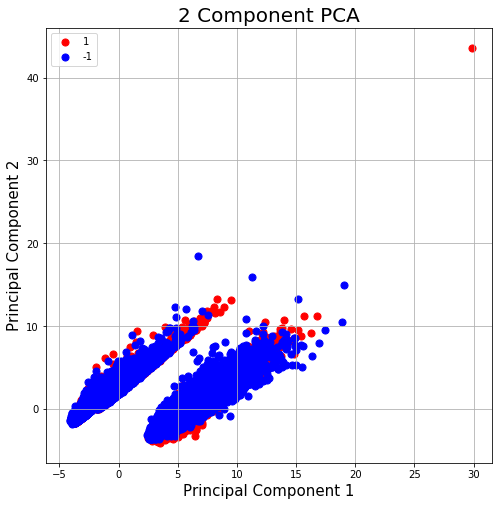

In [282]:
pca_plot(df)

# PCA (without -999)

Explained variance [0.29980084 0.11744543]


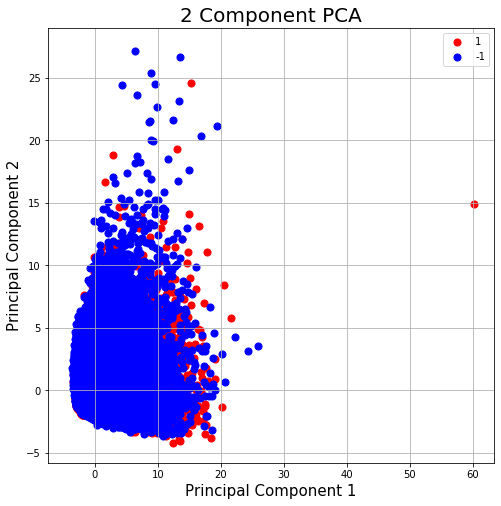

In [283]:
df_nan = df[df.columns[perc==0]]
pca_plot(df_nan)

# PCA (without high correlations)

Explained variance [0.15932455 0.13666957]


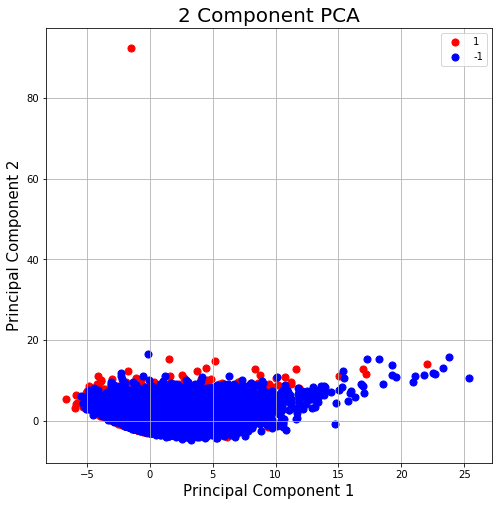

In [307]:
df_corr = df[keep]
pca_plot(df_corr)

# Correlation heatmatp

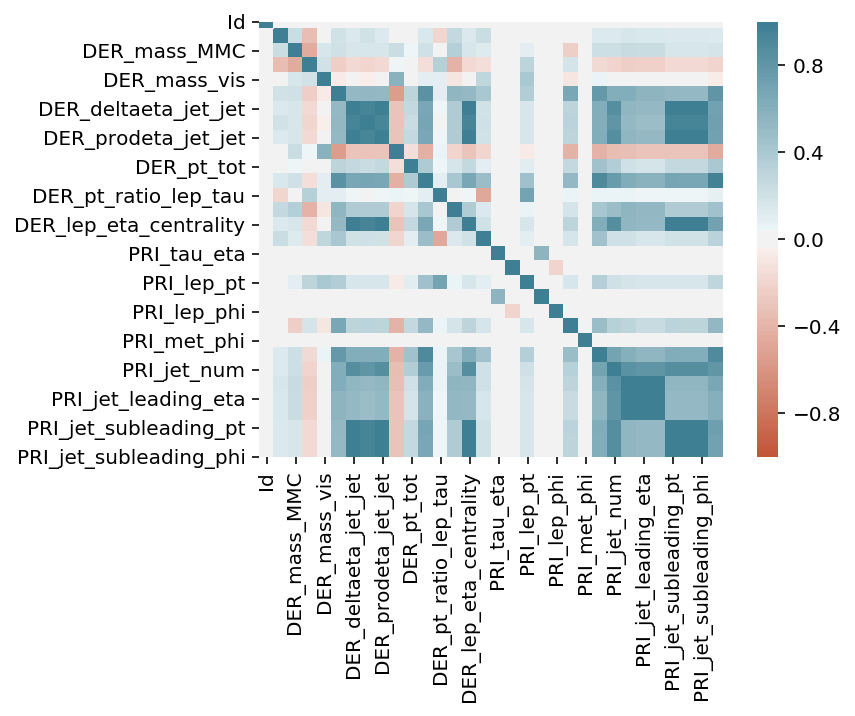

In [181]:
import seaborn as sns
corr = df.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

# Univariate selection with nans
ANOVA, only between one feature and the target. 

In [347]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
X_train = df.iloc[:,2:]
X_test = df_test.iloc[:,2:]
Y_train = df.iloc[:,1]
Y_test = df_test.iloc[:,1]
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

bestfeatures = SelectKBest(score_func=chi2, k=20)
fit = bestfeatures.fit(X_train,Y_train)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(df.iloc[:,2:].columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(20,'Score'))


                          Specs        Score
11       DER_met_phi_centrality  7233.900035
12       DER_lep_eta_centrality  3543.438361
4          DER_deltaeta_jet_jet  3538.884838
28       PRI_jet_subleading_phi  3529.738857
27       PRI_jet_subleading_eta  3525.390626
6           DER_prodeta_jet_jet  3445.377960
25          PRI_jet_leading_phi  2254.993867
24          PRI_jet_leading_eta  2251.998817
26        PRI_jet_subleading_pt  2160.876552
5              DER_mass_jet_jet  1674.977952
22                  PRI_jet_num  1450.128152
23           PRI_jet_leading_pt  1278.962678
1   DER_mass_transverse_met_lep  1135.144896
0                  DER_mass_MMC  1134.243391
13                   PRI_tau_pt   498.990853
9                    DER_sum_pt   387.328483
29               PRI_jet_all_pt   362.948770
10         DER_pt_ratio_lep_tau   248.303582
3                      DER_pt_h   228.766113
21                PRI_met_sumet   188.228864


In [ ]:
#Nans
#DER_mass_MMC
#DER_deltaeta_jet_jet          
#DER_mass_jet_jet               
#DER_prodeta_jet_jet            
#DER_lep_eta_centrality        
#PRI_jet_leading_pt           
#PRI_jet_leading_eta           
#PRI_jet_leading_phi            
#PRI_jet_subleading_pt          
#PRI_jet_subleading_eta    

# Univariate selection without nans

In [343]:
#Uses the dataframe without nans
df_test_nan = df_test[df_test.columns[perc==0]]
X_train = df_nan.iloc[:,2:]
X_test = df_test_nan.iloc[:,2:]
Y_train = df_nan.iloc[:,1]
Y_test = df_test_nan.iloc[:,1]

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

bestfeatures = SelectKBest(score_func=chi2, k=19)
fit = bestfeatures.fit(X_train,Y_train)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(df_nan.iloc[:,2:].columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(19,'Score'))

                          Specs        Score
7        DER_met_phi_centrality  7233.900035
17                  PRI_jet_num  1450.128152
0   DER_mass_transverse_met_lep  1135.144896
8                    PRI_tau_pt   498.990853
5                    DER_sum_pt   387.328483
18               PRI_jet_all_pt   362.948770
6          DER_pt_ratio_lep_tau   248.303582
2                      DER_pt_h   228.766113
16                PRI_met_sumet   188.228864
11                   PRI_lep_pt    11.254415
15                  PRI_met_phi     2.331214
3            DER_deltar_tau_lep     1.938088
14                      PRI_met     1.154386
1                  DER_mass_vis     0.818947
10                  PRI_tau_phi     0.812138
13                  PRI_lep_phi     0.701431
4                    DER_pt_tot     0.540469
12                  PRI_lep_eta     0.073886
9                   PRI_tau_eta     0.026376


In [344]:
keep

['Prediction',
 'DER_mass_MMC',
 'DER_mass_transverse_met_lep',
 'DER_mass_vis',
 'DER_deltar_tau_lep',
 'DER_pt_tot',
 'DER_pt_ratio_lep_tau',
 'DER_met_phi_centrality',
 'PRI_tau_pt',
 'PRI_tau_eta',
 'PRI_tau_phi',
 'PRI_lep_pt',
 'PRI_lep_eta',
 'PRI_lep_phi',
 'PRI_met',
 'PRI_met_phi']